## Test of neural network framework, written from scratch using numpy only

Author: Vladimir Surtaev
Date: November 2021

### MNIST classification

#### Data load and processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from framework import nn, optim

Loader takes the dataset and split it on batches

In [2]:
def loader(X, Y, batch_size):
    n = X.shape[0]

    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

Download and load mnist dataset

In [10]:
import os
from sklearn.datasets import fetch_openml

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    X = mnist.data / 255.0 # Normalizes mnist
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Since my cross entropy loss takes target vector, I need to transform target lable into vector:

In [11]:
def to_one_hot(y):
    y = np.array(y, dtype=np.int32)
    shape = (y.size, y.max() + 1)
    one_hot = np.zeros(shape)
    rows = np.arange(y.size)
    one_hot[rows, y] = 1
    return one_hot

In [12]:
y = to_one_hot(y)

Split X and y on train and test:

In [14]:
X_train, X_test = X[:50000], X[50000:60000]
y_train, y_test = y[:50000], y[50000:60000]

### Model:

In [23]:
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(),
    nn.BatchNorm(512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 64),
    nn.LeakyReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, 10),
    nn.SoftMax()
)


criterion = nn.CrossEntropy()

### Accuracy score:

Sinse we want to understand models accuracy and not something that shows cross-entropy

In [20]:
def accuracy(model, X, Y):
    model.eval()
    total = 0
    correct = 0
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        for i in range(x.shape[0]):
            if (y_pred[i][y_true[i] == 1] == y_pred[i].max()):
                correct += 1
            total += 1
    return correct / total


### Learning:

In [17]:
epochs = 50
batch_size = 512
learning_rate = 1e-3

0 0.94864 0.9528
1 0.96394 0.9644
2 0.97354 0.9693
3 0.97764 0.9736
4 0.97876 0.9729
5 0.98186 0.9742
6 0.9853 0.9781
7 0.98678 0.9792
8 0.98716 0.9763
9 0.9888 0.9773
10 0.9891 0.9799
11 0.99068 0.9807
12 0.98906 0.9786
13 0.99146 0.9794
14 0.99204 0.9799
15 0.99284 0.9803
16 0.99336 0.9807
17 0.99332 0.9804
18 0.99416 0.981
19 0.99486 0.9816
20 0.99466 0.9804
21 0.9947 0.9806
22 0.9954 0.9818
23 0.99572 0.982
24 0.9958 0.9825
25 0.99614 0.9827
26 0.99656 0.9826
27 0.99672 0.982
28 0.99698 0.9833
29 0.99636 0.9826
30 0.99716 0.9832
31 0.9975 0.9821
32 0.99764 0.9838
33 0.99734 0.983
34 0.9974 0.9832
35 0.99808 0.9843
36 0.99812 0.9825
37 0.9983 0.9845
38 0.99824 0.985
39 0.99828 0.9854
40 0.99812 0.9834
41 0.99778 0.9819
42 0.99848 0.9825
43 0.99846 0.9829
44 0.99868 0.9832
45 0.99858 0.9838
46 0.99882 0.9843
47 0.9987 0.9836
48 0.99874 0.9839
49 0.99922 0.9847


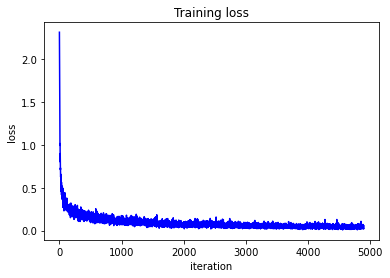

In [24]:
history = []
train_accuracy = []
test_accuracy = []

for i in range(epochs):
    model.train()
    for x, y_true in loader(X_train, y_train, batch_size):
        # forward propocation
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward propogation
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # weights update
        optim.SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
    
        # save the loss
        history.append(loss)
    train_accuracy.append(accuracy(model, X_train, y_train))
    test_accuracy.append(accuracy(model, X_test, y_test))
    print(i, train_accuracy[-1], test_accuracy[-1])

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

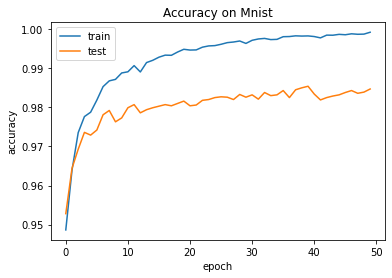

In [26]:
plt.plot([i for i in range(len(train_accuracy))], train_accuracy, test_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train','test'))
plt.title("Accuracy on Mnist")
plt.show()